In [ ]:
# https://www.kaggle.com/vladlee/ion-lstm-baseline-feature-selection

In [59]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model

#from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import LSTM, Bidirectional, add, concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Conv2DTranspose, AveragePooling1D, UpSampling1D
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation, TimeDistributed
from tensorflow.keras.layers import Multiply, Add, Concatenate, Flatten, Average, Lambda

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.constraints import unit_norm, max_norm
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.utils import np_utils

from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix

In [2]:
train_df = pd.read_csv('train_detrendbyhist.csv', dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})
test_df = pd.read_csv('test_detrendbyhist.csv', dtype={'time': np.float32, 'signal': np.float32})


In [3]:
train_df.head(2)

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0


In [54]:
import tensorflow.keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

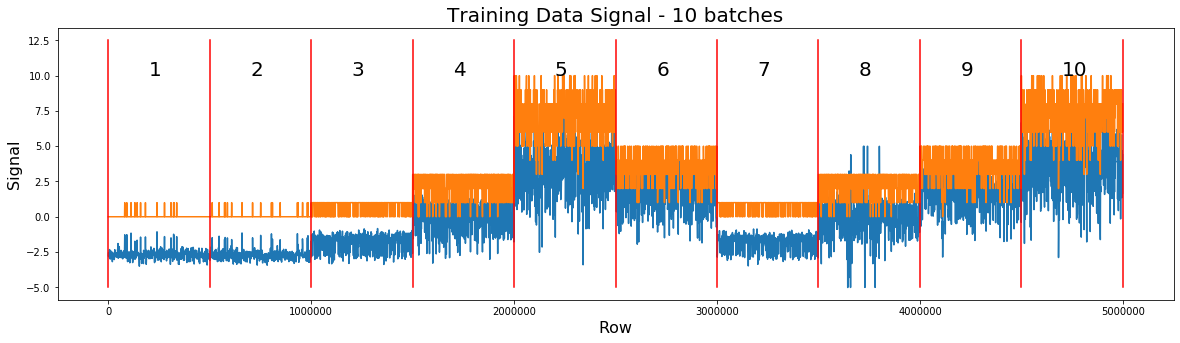

In [4]:
plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,train_df.shape[0],res),train_df.signal[0::res])
plt.plot(range(0,train_df.shape[0],res),train_df.open_channels[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Training Data Signal - 10 batches',size=20)
plt.show()

In [5]:
def normalize(train, test):
    train_input_mean = train.signal.mean()
    train_input_sigma = train.signal.std()
    train['signal'] = (train.signal - train_input_mean) / train_input_sigma
    test['signal'] = (test.signal - train_input_mean) / train_input_sigma
    return train, test

In [6]:
# # get lead and lags features
# def lag_with_pct_change(df, windows):
#     for window in windows:    
#         df['signal_shift_pos_' + str(window)] = df.groupby('group')['signal'].shift(window).fillna(0)
#         df['signal_shift_neg_' + str(window)] = df.groupby('group')['signal'].shift(-1 * window).fillna(0)
#     return df

In [7]:
train_df, test_df = normalize(train_df,test_df)


In [12]:
# grouping
train_segm_separators = np.concatenate([[0,500000], np.arange(1000000,5000000+1,500000)])
train_segm_signal_groups = [0,0,1,2,4,3,1,2,3,4]
test_segm_separators = np.concatenate([np.arange(0,1000000+1,100000), [1500000,2000000]])
test_segm_signal_groups = [0,2,3,0,1,4,3,4,0,2,0,0] # from visual id
test_segm_separators


tmp = np.zeros(train_df.shape[0])
for i, group in enumerate(train_segm_signal_groups):
    tmp[train_segm_separators[i]:train_segm_separators[i+1]] = group
train_df['group'] = tmp
train_df['group'] = train_df['group'].astype(int)

tmp = np.zeros(test_df.shape[0])
for i, group in enumerate(test_segm_signal_groups):
    tmp[test_segm_separators[i]:test_segm_separators[i+1]] = group
test_df['group'] = tmp
test_df['group'] = test_df['group'].astype(int)

# train_df['group']

In [16]:
train_df

,time,signal,open_channels,group
0,0.000100,-1.141844,0,0
1,0.000200,-1.180219,0,0
2,0.000300,-1.000453,0,0
3,0.000400,-1.294382,0,0
4,0.000500,-1.299234,0,0
...,...,...,...,...
4999995,499.999603,1.140847,7,4
4999996,499.999695,1.052079,7,4
4999997,499.999786,1.781260,8,4
4999998,499.999908,2.231709,9,4


## Modeling

In [14]:
def baseline_model(input_shape, units = 64, max_channels = 11, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, input_shape=(input_shape[1], input_shape[2]), return_sequences=True))
    model.add(LSTM(units, return_sequences=True))
    model.add(LSTM(units, return_sequences=True))
    model.add(LSTM(units, return_sequences=True))
    model.add(LSTM(units))
    model.add(Dense(units))
    model.add(Dense(max_channels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc', f1])
    return model

In [31]:
#get dummy
train_df = pd.concat([train_df.drop(['group'],axis =1),pd.get_dummies(train_df['group'],prefix = 'group',dummy_na=False)], axis =1)
test_df = pd.concat([test_df.drop(['group'],axis =1),pd.get_dummies(test_df['group'],prefix = 'group',dummy_na=False)], axis =1)


In [69]:
seed =999
# Data 분리
X_train = train_df.drop(['time','open_channels'],axis =1)
X_test = test_df.drop(['time'],axis =1)
Y_train = train_df['open_channels']

# reshape
X_train= X_train.values.reshape(-1,X_train.shape[1],1)
X_test= X_test.values.reshape(-1,X_test.shape[1],1)

## using categorical_crossentropy
Y_train = to_categorical(Y_train, num_classes=11)

# Train_valid 분리
train_idx, val_idx = train_test_split(np.arange(X_train.shape[0]), random_state = seed, test_size = 0.2)

x_train ,y_train  = X_train[train_idx],Y_train[train_idx]
x_valid, y_valid = X_train[val_idx], Y_train[val_idx]



In [84]:
x_train.shape

(4000000, 6, 1)

In [57]:
%%time

BATCH_SIZE = 1280
EPOCHS = 20

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.000001, verbose=1)

adam = Adam(0.005)

model = baseline_model(x_train.shape, optimizer=adam)
history = model.fit( x_train, y_train, validation_data=(x_valid, y_valid), callbacks=[es,lr],
                    batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
                    shuffle=False, workers=8, use_multiprocessing=True )

Train on 4000000 samples, validate on 1000000 samples
Epoch 1/20
4000000/4000000 [==============================] - 43s 11us/sample - loss: 0.1556 - acc: 0.9420 - f1: 0.8835 - val_loss: 0.1096 - val_acc: 0.9587 - val_f1: 0.9220
Epoch 2/20
4000000/4000000 [==============================] - 38s 9us/sample - loss: 0.1107 - acc: 0.9585 - f1: 0.9205 - val_loss: 0.1109 - val_acc: 0.9579 - val_f1: 0.9125
Epoch 3/20
4000000/4000000 [==============================] - 37s 9us/sample - loss: 0.1097 - acc: 0.9590 - f1: 0.9212 - val_loss: 0.1049 - val_acc: 0.9606 - val_f1: 0.9242
Epoch 4/20
4000000/4000000 [==============================] - 38s 9us/sample - loss: 0.1074 - acc: 0.9598 - f1: 0.9227 - val_loss: 0.1080 - val_acc: 0.9603 - val_f1: 0.9241
Epoch 5/20
4000000/4000000 [==============================] - 38s 9us/sample - loss: 0.1071 - acc: 0.9598 - f1: 0.9231 - val_loss: 0.1099 - val_acc: 0.9598 - val_f1: 0.9244
Epoch 6/20
4000000/4000000 [==============================] - 38s 9us/sample - l

## Evaluate Model

In [66]:
y_pred = np.argmax(model.predict(x_valid), axis=1).reshape(-1)
yhat =train_df['open_channels'][val_idx].values
print("F1 MACRO: ", f1_score(yhat, y_pred, average="macro"))

F1 MACRO:  0.9273567401199482


In [70]:
y_pred = np.argmax(model.predict(X_test), axis=1).reshape(-1)

In [71]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [72]:
from datetime import datetime
sub = pd.read_csv("data/sample_submission.csv", dtype={'time':str})
sub.open_channels = np.array(np.round(y_pred,0), np.int)
sub.to_csv("submission_"+ str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.csv', index=False)

In [83]:
# pd.DataFrame(y_pred)[0].value_counts()

0     1223830
1      219563
3      134254
2      112493
4       79947
5       56608
7       53907
8       47533
6       36497
9       28773
10       6595
Name: 0, dtype: int64